# Example of using LiteQTL

This notebook showcase how to use LiteQTL to perform a QTL scan.

### Dataset: 
We use the BXD Genotype Database (GN Accession: GN600) and a sets of transcriptome data, UTHSCAffy MoGene 1.0 ST Spleen (GN Accession: GN283) from GeneNetwork. 

The genotype file includes 7321 markers by 198 BXD strains; 

The spleen dataset has data for 79 BXD strains and for 35556 transcripts. 

Data cleaning and wrangling was performed using R/qtl (Broman et al. 2003) and R/qtl2 (Broman et al. 2019). 

For details regarding data cleaning, please see [this script](https://github.com/senresearch/LiteQTL-G3-supplement/blob/master/code/clean-data.R)

In [1]:
# Loading packages
using LiteQTL
using DelimitedFiles
using BenchmarkTools
using CSV
using DataFrames

In [2]:
# Location of genotype file and phenotype file
geno_file = joinpath(@__DIR__, "..", "data", "processed", "spleen-bxd-genoprob.csv")
pheno_file = joinpath(@__DIR__, "..", "data","processed", "spleen-pheno-nomissing.csv")
gmap_file = joinpath(@__DIR__, "..", "data","processed", "gmap.csv")
phenocovar_file = joinpath(@__DIR__, "..", "data","processed", "phenocovar.csv")

# Whether to output whole LOD matrix or only maximum LOD of each phenotype? Default is false (only maximum)
export_matrix = false

# Location of output 
output_file = "output.csv"

# Setting BLAS threads as 16 threads. 
LiteQTL.set_blas_threads(16);

# Read in data.
G = get_geno_data(geno_file, Float64)
Y = get_pheno_data(pheno_file, Float64, transposed=false)
# getting geno and pheno file size.
n = size(Y,1) # number of individuals
m = size(Y,2) # number of Traits
p = size(G,2) # number of Markers
println("******* Indivuduals n: $n, Traits m: $m, Markers p: $p ****************");

Number of threads using: 16


┌ Info: Removing sex column of phenotype. 
└ @ LiteQTL /home/xiaoqihu/.julia/dev/LiteQTL/src/data_io.jl:29


******* Indivuduals n: 79, Traits m: 35554, Markers p: 7321 ****************


In [3]:
# running analysis without covariates.
@time lodc = scan(Y, G, export_matrix=export_matrix, maf_threshold=0.00, usegpu=false, lod_or_pval="lod");

if !export_matrix 
    gmap = CSV.read(gmap_file, DataFrame)
    idx = trunc.(Int, lodc[:,1])
    gmap_lod = hcat(gmap[idx,:], DataFrame(lodc, [:idx, :maxlod]))
end

 15.716617 seconds (22.42 M allocations: 3.048 GiB, 2.67% gc time)


,Locus,Chr,cM,Mb,idx,maxlod
,String,String,Float64,Float64,Float64,Float64
1,rs29125938,12,19.09,45.6632,5046.0,2.03595
2,rs32586510,7,20.49,36.9033,3111.0,2.74552
3,rs29672857,18,15.32,31.5562,6631.0,2.38099
4,rs31601065,18,15.32,31.8856,6632.0,3.03683
5,rs51367649,13,23.04,54.614,5326.0,2.6874
6,rs51367649,13,23.04,54.614,5326.0,2.93972
7,rs29222533,13,23.04,53.4775,5325.0,3.40571
8,rs13479203,7,22.29,39.9179,3120.0,2.73382
9,rs49250542,7,34.76,68.5198,3214.0,1.93849


In [4]:
# Uncomment the following lines to run the same function but with GPU: 
# lod = scan(Y, G, n; usegpu=true)
# @benchmark scan(Y, G, n; usegpu=true)

In [5]:
# run genome scan with covariates. 
# X is covariates
# X = ones(size(pheno)[1]) # standard covariates

# Use the first column of phenotype as covariates. 
# X = reshape(Y[:,1], :,1) # make 1 column as a 2d matrix
# Y = Y[:,2:end]

# @time lod = scan(Y, G, X, n; export_matrix)

In [6]:
# generate plot 
using Plots
using Colors
pyplot()
using Plots.PlotMeasures
using ColorSchemes

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [7]:
##### Match Pheno covar probeset. 
# phenocovar_file = joinpath(@__DIR__, "..", "data","processed", "phenocovar.csv")
phenocovar = CSV.read(phenocovar_file, DataFrame);
pheno = CSV.read(pheno_file, DataFrame);

In [8]:
########################Pheno Covar####################################

# removing Unknown Chromosome on phenotype.
newphenocovar = filter(:Chr => in(["Un", "X", "Y", "M", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"]), phenocovar)
rename!(newphenocovar, Dict(:Mb => :phenocovar_mb))
rename!(newphenocovar, Dict(:Chr => :phenocovar_chr)) 
newphenocovar[:, :acc_phenocovar_mb] .= newphenocovar.phenocovar_mb

gmap[:, :acc_mb] .= gmap.Mb
steps = Array{Float64}(undef, 20)
for i in 1:19
    thischrphenocovar = filter(:phenocovar_chr => x-> x==(string(i)), newphenocovar)
    thischrgmap = filter(:Chr => x-> x==(string(i)), gmap)
    steps[i] = max(maximum(thischrgmap.acc_mb), maximum(thischrphenocovar.acc_phenocovar_mb) ) 
    
    if i != 19 
        nextchrphenocovar = view(newphenocovar, newphenocovar.phenocovar_chr .== string(i+1), :)
        nextchrgmap = view(gmap, gmap.Chr .== string(i+1), :) 
    else 
        nextchrphenocovar = view(newphenocovar, newphenocovar.phenocovar_chr .== "X", :) 
        nextchrgmap = view(gmap, gmap.Chr .== "X", :)  
    end
    nextchrphenocovar.acc_phenocovar_mb .= nextchrphenocovar.phenocovar_mb .+ steps[i]
    nextchrgmap.acc_mb .= nextchrgmap.Mb .+ steps[i]
    
end
steps[20] = max(maximum(newphenocovar.acc_phenocovar_mb),maximum(gmap.acc_mb))


idx = trunc.(Int, lodc[:,1])
gmap_lod = hcat(gmap[idx,:], DataFrame(lodc, [:idx, :maxlod]))

,Locus,Chr,cM,Mb,acc_mb,idx,maxlod
,String,String,Float64,Float64,Float64,Float64,Float64
1,rs29125938,12,19.09,45.6632,1749.07,5046.0,2.03595
2,rs32586510,7,20.49,36.9033,1054.76,3111.0,2.74552
3,rs29672857,18,15.32,31.5562,2500.97,6631.0,2.38099
4,rs31601065,18,15.32,31.8856,2501.3,6632.0,3.03683
5,rs51367649,13,23.04,54.614,1879.27,5326.0,2.6874
6,rs51367649,13,23.04,54.614,1879.27,5326.0,2.93972
7,rs29222533,13,23.04,53.4775,1878.13,5325.0,3.40571
8,rs13479203,7,22.29,39.9179,1057.78,3120.0,2.73382
9,rs49250542,7,34.76,68.5198,1086.38,3214.0,1.93849


In [ ]:
phenocovar_gmap_lod = hcat(newphenocovar, gmap_lod)
phenocovar_gmap_lod = filter(:phenocovar_chr => !in(["Un", "Y", "M"]), covar_gmap_lod)

In [11]:
gr()

Plots.GRBackend()

(1892, 11)


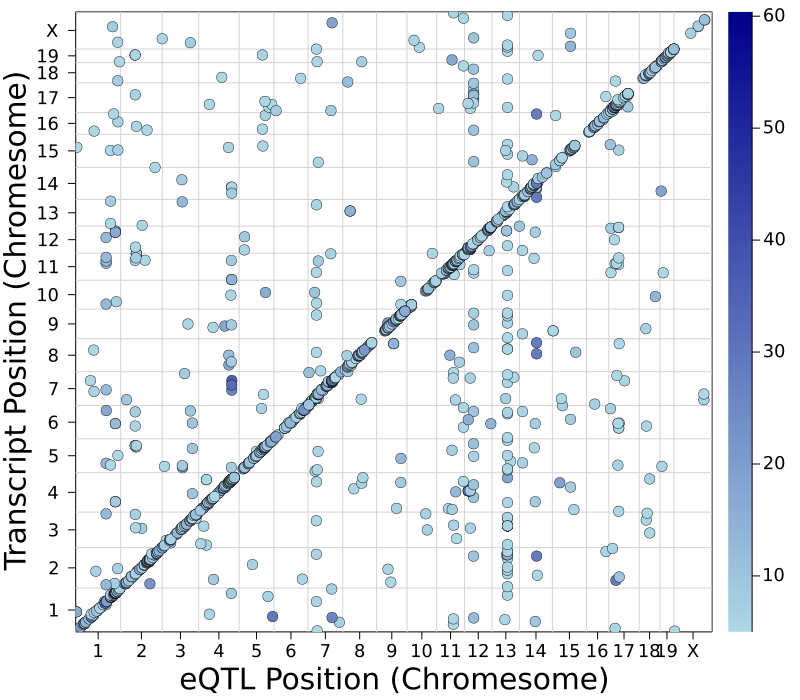

In [20]:

chrnum = ["1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19", "X"]
# filter out all chromesome without missing value. 
testdf = filter(:phenocovar_chr => in(chrnum), phenocovar_gmap_lod)
# filter out the ones with LOD score above 5
testdf = filter(:maxlod => x -> x > 5, testdf)
# filter out the onese that has the different transcript positions (they are considered same if they are within 10 Mb positions)
# testdf = testdf[.!(isapprox.(testdf[:phenocovar_mb],testdf[:Mb], atol=10) .& (testdf[:phenocovar_chr] .== testdf[:Chr])), :] 

println(size(testdf))
# testdf1 = filter(:maxlod => x -> x < 10.0 && x > 5, testdf)
# testdf2 = filter(:maxlod => x -> x >= 10.0, testdf)
### 

function pseudotick(tick)
    minortick = zeros(size(tick,1))
    for i in 1:size(tick,1)
        if i == 1
            minortick[i] = tick[i]/2
        else
            minortick[i] = tick[i-1] + (tick[i] - tick[i-1])/2
        end 
    end   
    return minortick
end

xlim = steps[end]
ylim = xlim
x = collect(0:xlim)
y = collect(0:ylim)

# vtest = floor.(testdf.maxlod ./ 10) .* 10


# C(g::ColorGradient) = RGB[g[z] for z=LinRange(0,1,30)]
# gcolor = cgrad([:orange, :blue, :darkblue])
# gcolor = cgrad(:blues, 5, categorical = true)
gcolor = cgrad(:blues)
vline(steps, color="lightgrey",label="")
hline!(steps, color="lightgrey",label="")

p2=scatter!(testdf.acc_mb,testdf.acc_phenocovar_mb,
#     marker_z=testdf.maxlod,
    framestyle=:box,
#      marker_z=vtest,
    marker_z=testdf.maxlod,
    color=gcolor, 
#     c=(cgrad(:blues) |> C), 
#     label="5 < LOD < 10",
    legend=false,
#     colorbar_ticks = ([0,10,20,30,40,50],[0,10,20,30,40,50]),
    size=(800,700),
    xticks=(pseudotick(steps), chrnum), yticks=(pseudotick(steps), chrnum),tickfontsize=12,tick_direction=:out,
    xlims=(0,xlim),ylims=(0,ylim),
    xlab="eQTL Position (Chromesome)",ylab="Transcript Position (Chromesome)",
    grid=false,guidefontsize=20,
    marker=6, markerstrokewidth=0.3,
    bottom_margin=0mm,right_margin=0mm)

# scatter!(testdf2.acc_mb,testdf2.acc_phenocovar_mb,label="LOD > 10",marker=6, markercolor="#ca0020", markerstrokewidth=0.3)



In [16]:
testdf.maxlod

744-element Array{Float64,1}:
 25.065249050464747
 24.171331870972566
 38.98850707194237
 23.38850950321284
 19.65885834245765
 16.469525191531964
 25.97709546709938
 28.802741669969382
 11.897613495291242
 11.615354864168893
 20.455768037048486
 10.88007885494192
 11.313480927810781
  ⋮
 26.889830204038738
 22.509344842313762
 12.00191784561607
 10.578833575056272
 21.407391384810396
 15.828351898543927
 13.480099504905033
 10.042087834237078
 18.397469321849083
 10.83569703033466
 23.227212494099856
 16.05093558185556

In [13]:
CSV.write("LOD10.csv", testdf)

"LOD10.csv"

In [21]:
savefig(p2, "scatterplot.png")

In [15]:
names(testdf)

11-element Array{String,1}:
 "ProbeSet"
 "phenocovar_chr"
 "phenocovar_mb"
 "acc_phenocovar_mb"
 "Locus"
 "Chr"
 "cM"
 "Mb"
 "acc_mb"
 "idx"
 "maxlod"

In [ ]:
# write output to file
writedlm(joinpath(Base.@__DIR__, "..", "data", "results", output_file), lod, ',')